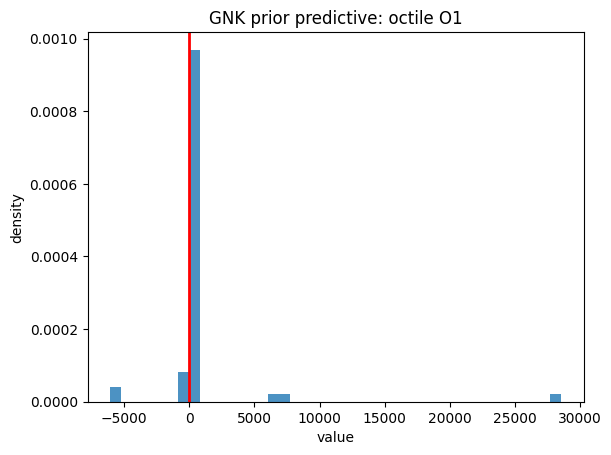

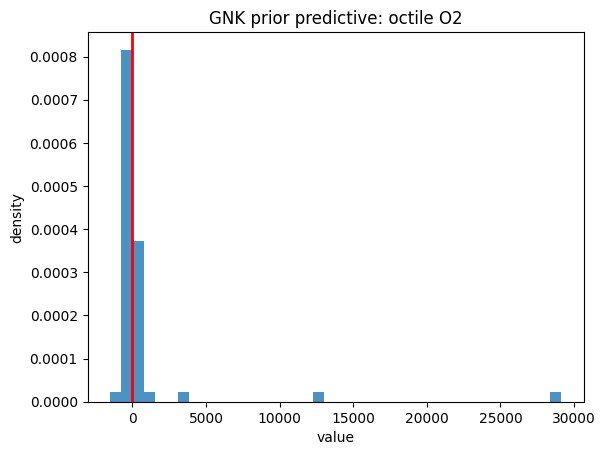

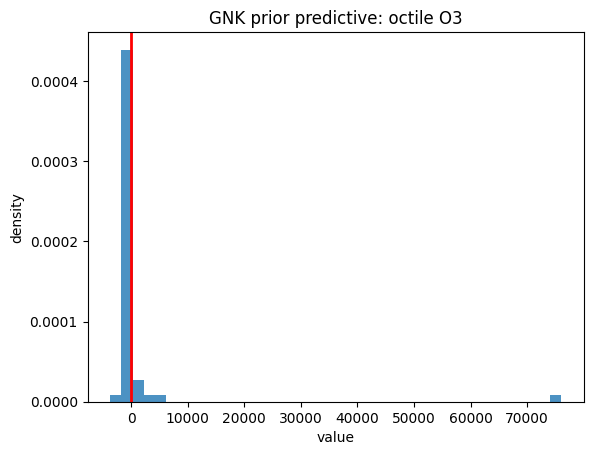

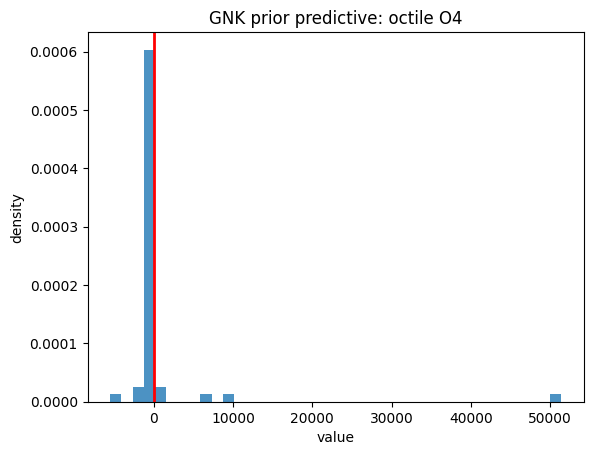

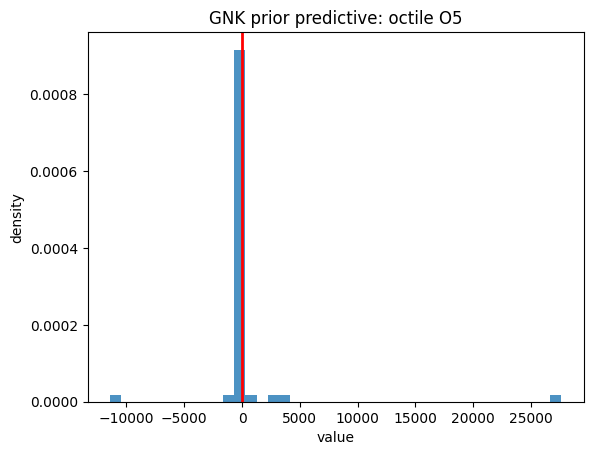

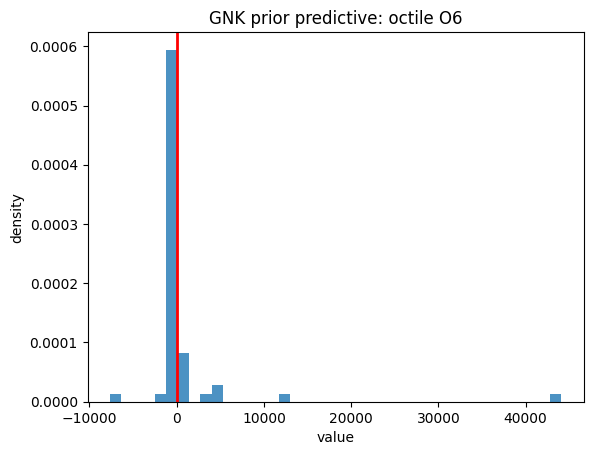

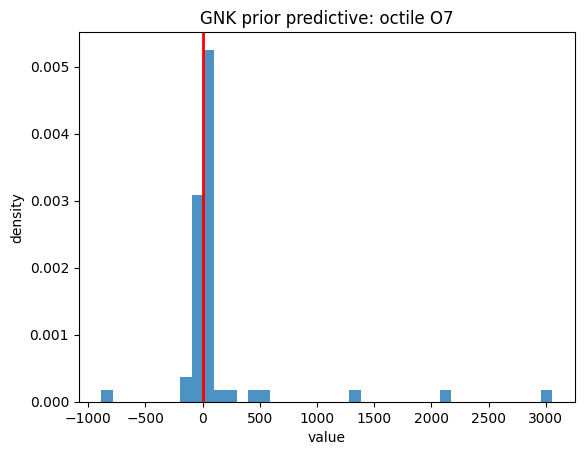

In [2]:
# plot_prior_predictive_gnk.py
from __future__ import annotations
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp
from jax import random
from typing import Tuple
from precond_npe_misspec.examples.gnk import (
    get_summaries_batches,
    ss_octile,
    ss_robust,
    true_dgp,
)

Array = jax.Array


def prior_sample(
    key: Array,
    n: int,
    A: Tuple[float, float] = (0.0, 10.0),
    B: Tuple[float, float] = (0.0, 10.0),
    g: Tuple[float, float] = (0.0, 10.0),
    k: Tuple[float, float] = (0.0, 10.0),
) -> jnp.ndarray:
    kA, kB, kg, kk = random.split(key, 4)
    u = lambda k_, lo, hi: lo + random.uniform(k_, (n,)) * (hi - lo)
    B_lo = max(B[0], 1e-3)  # avoid degenerate B=0
    A_, B_, g_, k_ = u(kA, *A), u(kB, B_lo, B[1]), u(kg, *g), u(kk, *k)
    return jnp.stack([A_, B_, g_, k_], axis=1)  # (n,4)


key = random.key(0)
n_obs, n_sims, batch_size = 2000, 2000, 250

key, k_theta, k_sims, k_obs = random.split(key, 4)
theta = prior_sample(k_theta, n_sims)  # (n_sims,4)
A, B, g, k = theta.T
# pseudo_true = jnp.array([4.16, 3.35, 1.1, 0.135])

S = get_summaries_batches(
    k_sims,
    A,
    B,
    g,
    k,
    n_obs=n_obs,
    n_sims=n_sims,
    batch_size=batch_size,
    sum_fn=ss_octile,
).T  # (n_sims,7)
y_obs = true_dgp(k_obs, n_obs)
s_obs = ss_octile(y_obs)  # (7,)

for i in range(7):
    plt.figure()
    plt.hist(S[:, i], bins=40, density=True, alpha=0.8)
    plt.axvline(float(s_obs[i]), color="red", linewidth=2)
    plt.title(f"GNK prior predictive: octile O{i+1}")
    plt.xlabel("value")
    plt.ylabel("density")
plt.show()

(array([ 69., 140.,   8.,  51., 229., 504., 574., 303., 107.,  15.]),
 array([-0.89723063,  2.47559834,  5.8484273 ,  9.22125626, 12.59408569,
        15.96691513, 19.33974266, 22.7125721 , 26.08540154, 29.45823097,
        32.8310585 ]),
 <BarContainer object of 10 artists>)

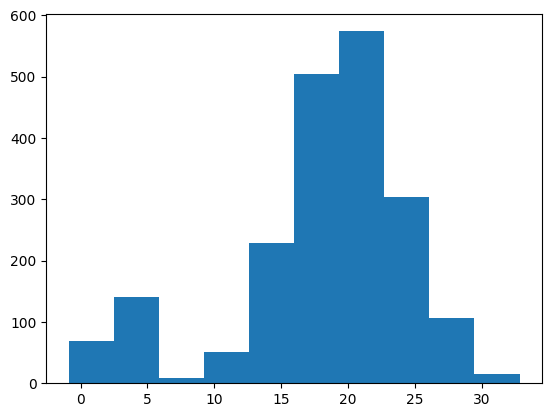

In [19]:
plt.hist(y_obs)

In [2]:
jnp.min(S[:, 3])

Array(-5496.7124, dtype=float32)

In [8]:
s_obs

Array([ 1.1676249e+02,  2.1748581e+00, -8.2402840e-02,  1.5141214e+00],      dtype=float32)

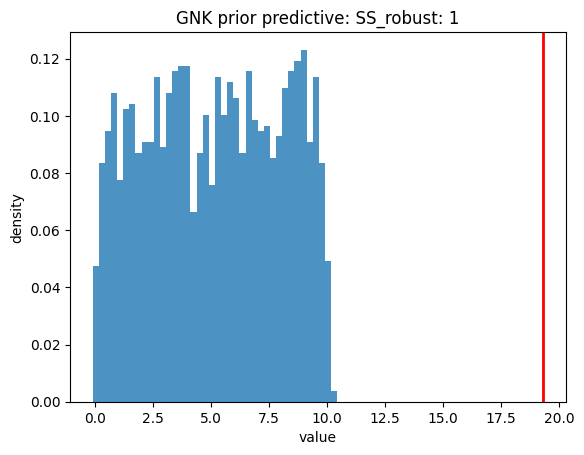

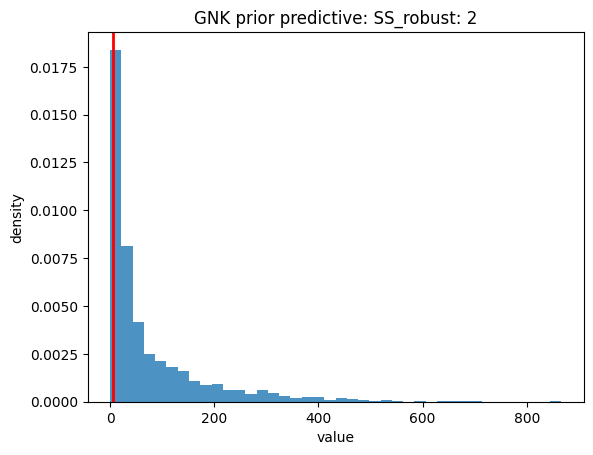

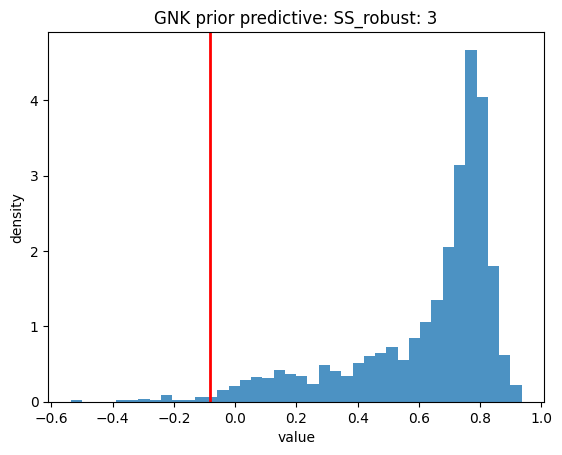

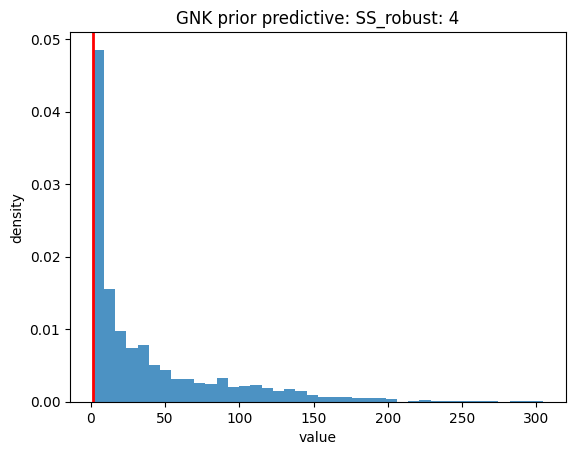

In [ ]:
from typing import Any

key = random.key(0)
n_obs, n_sims, batch_size = 2000, 2000, 250

key, k_theta, k_sims, k_obs = random.split(key, 4)
theta = prior_sample(k_theta, n_sims)  # (n_sims,4)
A, B, g, k = theta.T


# def true_dgp(
#     key: Any,
#     n_obs: int,
#     w: float = 0.1,
#     mu1: float = 3.0,
#     var1: float = 2.0,
#     mu2: float = 20.0,
#     var2: float = 16.0,
# ) -> Array:
#     """Generate n_obs iid draws from the misspecified mixture."""
#     k_z, k1, k2 = random.split(key, 3)
#     z = random.bernoulli(k_z, p=w, shape=(n_obs,))  # 1 -> comp 1, 0 -> comp 2
#     y1 = mu1 + jnp.sqrt(var1) * random.normal(k1, (n_obs,))  # N(μ1, σ1^2)
#     y2 = mu2 + jnp.sqrt(var2) * random.normal(k2, (n_obs,))  # N(μ2, σ2^2)
#     return z * y1 + (1.0 - z) * y2


S = get_summaries_batches(
    k_sims,
    A,
    B,
    g,
    k,
    n_obs=n_obs,
    n_sims=n_sims,
    batch_size=batch_size,
    sum_fn=ss_robust,
).T  # (n_sims,7)
y_obs = true_dgp(k_obs, n_obs)
s_obs = ss_robust(y_obs)  # (7,)

for i in range(4):
    plt.figure()
    plt.hist(S[:, i], bins=40, density=True, alpha=0.8)
    plt.axvline(float(s_obs[i]), color="red", linewidth=2)
    plt.title(f"GNK prior predictive: SS_robust: {i+1}")
    plt.xlabel("value")
    plt.ylabel("density")
plt.show()

PRNPE: mean=1.3149, sd=0.7713, q05/50/95=(0.5592638254165649, 1.025350570678711, 2.930154800415039)
PNPE: mean=0.9374, sd=0.3841, q05/50/95=(0.519859254360199, 0.8598244190216064, 1.6001713275909424)


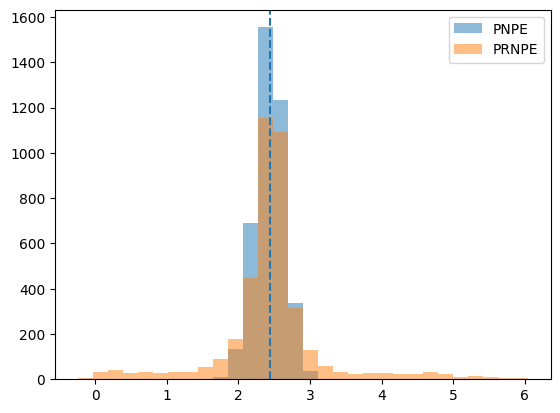

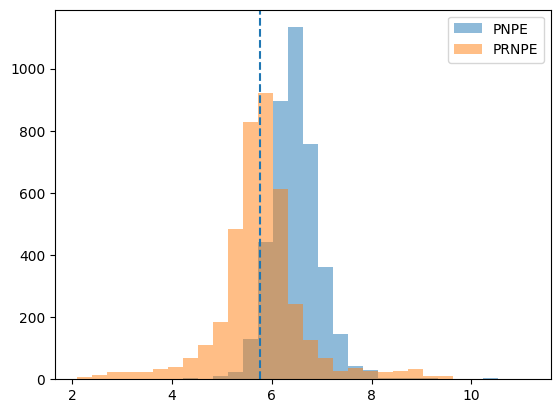

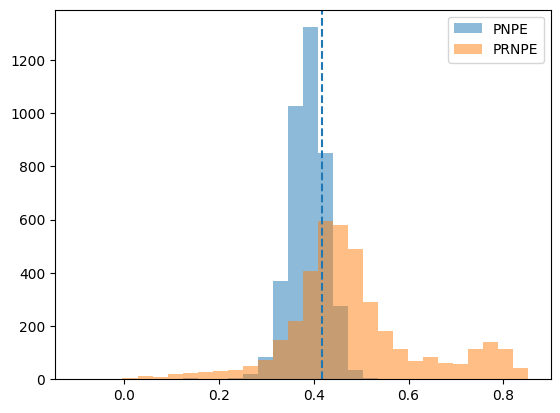

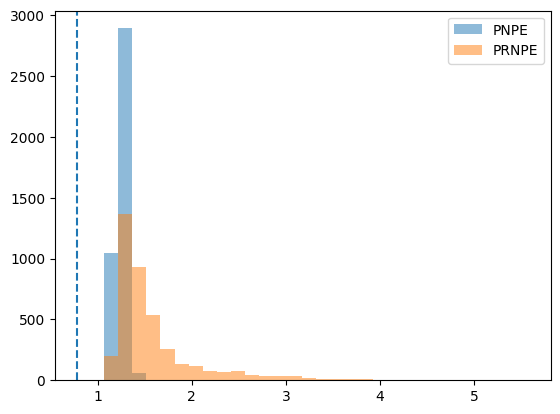

In [14]:
import numpy as np

# posterior predictive

# read in PNPE posterior samples
pnpe_filename = "/Users/ryankelly/python_projects/preconditioned-npe-under-misspecification/results/gnk/pnpe/th_A3.0_B1.0_g2.0_k0.5-n_obs_5000-n_sims_20000-q_0.2/seed-0/20250915-132458/posterior_samples.npz"
d = np.load(pnpe_filename)
pnpe_thetas = d["samples"]

# read in PRNPE posterior samples
prnpe_filename = "/Users/ryankelly/python_projects/preconditioned-npe-under-misspecification/results/gnk/prnpe/th_A3.0_B1.0_g2.0_k0.5-n_obs_5000-n_sims_20000-q_0.2/seed-0/20250915-132501/posterior_samples_robust.npz"
d = np.load(prnpe_filename)
prnpe_thetas = d["samples"]

s_obs_filename = "/Users/ryankelly/python_projects/preconditioned-npe-under-misspecification/results/gnk/pnpe/th_A3.0_B1.0_g2.0_k0.5-n_obs_5000-n_sims_20000-q_0.2/seed-0/20250915-132458/s_obs.npy"
s_obs = np.load(s_obs_filename)

key = random.key(0)
n_draw = int(jnp.minimum(4000, pnpe_thetas.shape[0]))
idx = random.choice(key, pnpe_thetas.shape[0], (n_draw,), replace=False)
A, B, g, k = pnpe_thetas[idx].T
S_pnpe = get_summaries_batches(
    key, A, B, g, k, n_obs=n_obs, n_sims=n_draw, batch_size=256, sum_fn=ss_robust
).T

A, B, g, k = prnpe_thetas[idx].T
S_prnpe = get_summaries_batches(
    key, A, B, g, k, n_obs=n_obs, n_sims=n_draw, batch_size=256, sum_fn=ss_robust
).T
d = jnp.linalg.norm(S_prnpe - s_obs[None, :], axis=1)
q = jnp.quantile(d, jnp.array([0.05, 0.5, 0.95]))
print(
    f"PRNPE: mean={d.mean():.4f}, sd={d.std():.4f}, q05/50/95={tuple([float(x) for x in q])}"
)

d = jnp.linalg.norm(S_pnpe - s_obs[None, :], axis=1)
q = jnp.quantile(d, jnp.array([0.05, 0.5, 0.95]))
print(
    f"PNPE: mean={d.mean():.4f}, sd={d.std():.4f}, q05/50/95={tuple([float(x) for x in q])}"
)


# plot PPC plots for summaries
for i in range(4):
    edges = np.histogram_bin_edges(
        np.concatenate([S_pnpe[:, i], S_prnpe[:, i]]), bins=30
    )

    # 2) plot both with the same `bins`
    plt.hist(S_pnpe[:, i], bins=edges, alpha=0.5, label="PNPE")
    plt.hist(S_prnpe[:, i], bins=edges, alpha=0.5, label="PRNPE")
    plt.axvline(s_obs[i], linestyle="--")
    plt.legend()
    plt.show()